# Assignment 12 - Bayesian simulation

### 1. Testing bayesian simulation for our dataset to find an optimal fit.

In [58]:
# Adding the necessary libraries for testing different distributions and performing statistical calculations

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

# Data Set: Forest Fires
The data set contains information about forest fires, likely relevant for predicting or understanding fire behavior. Here's a breakdown of the columns:

Y: This column seems to represent some sort of categorical identifier. Without further context, it's hard to determine its exact meaning.

month: Indicates the month in which the forest fire occurred.

day: Indicates the day of the week when the forest fire occurred.

FFMC: Fine Fuel Moisture Code - a numeric rating of the moisture content of litter and other cured fine fuels.

DMC: Duff Moisture Code - a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth.

DC: Drought Code - a numeric rating of the average moisture content of deep, compact organic layers.

ISI: Initial Spread Index - a numeric rating of the expected rate of fire spread.

temp: Temperature in Celsius at the time of the observation.

RH: Relative humidity in percentage at the time of the observation.

wind: Wind speed in km/h at the time of the observation.

rain: Outside rain in mm/m² in the 24 hours preceding the observation.

area: The area of the forest affected by the fire, in hectares.

In [2]:
df = pd.read_csv('forestfires.csv', index_col=0) # Reading the data set

df.head() 

,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,,,,,,,,,,,,
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
df.isnull().sum() #Checking for null values

Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

## Plotting the Distributions of the Independent Features

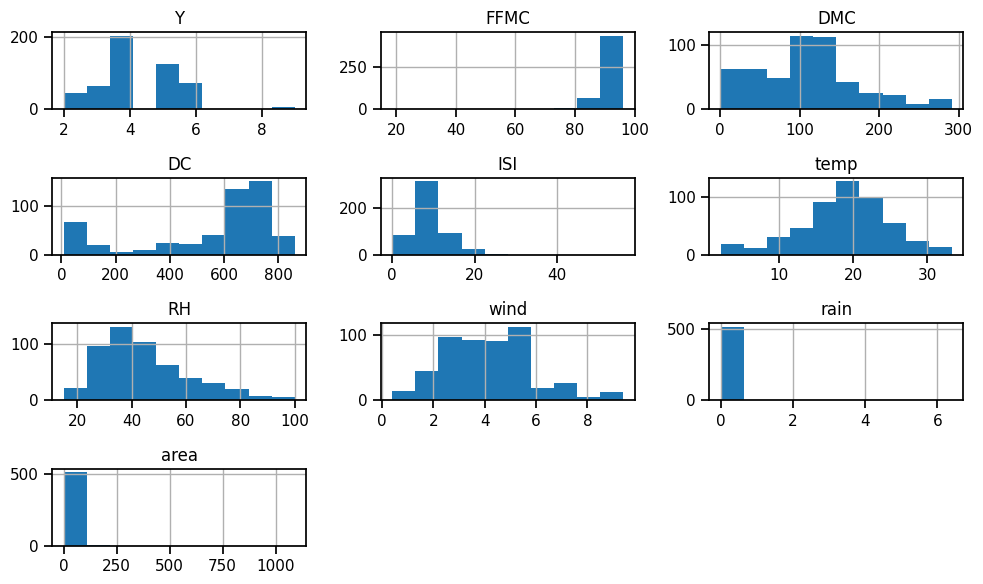

In [4]:
df.hist(figsize=(10, 6), bins=10)  # Adjust figsize and bins as needed
plt.tight_layout()
plt.show()

In [7]:
# Calculating mean and standard deviation for "temp" column

mean = df['temp'].mean()
std = df['temp'].std()
print("Mean: ", mean, "\nStandard Deviation: ", std)

Mean:  18.88916827852998 
Standard Deviation:  5.806625349573505


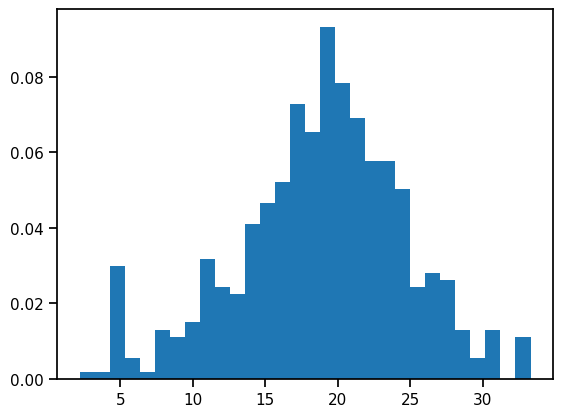

In [10]:
import matplotlib.pyplot as plt

# df.temp contains temperature data

plt.hist(df.temp, density=True, bins=30)
plt.show()

## Modeling Gamma parameters with a Uniform distribution

####  The Uniform distribution to model the  𝛼 parameter for our gamma function. The Uniform distribution also needs start and end parameters. We pick them to be wide enough to match the data. Then we model temperature data with the Gamme distribution.

In [59]:
# parameter modeling for uniform distribution

from pymc3 import Model, Uniform

with Model() as forest_fires_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)

In [14]:
# data likelihood modeling

from pymc3 import Gamma
with forest_fires_model:
    forest_like = Gamma('forest_like', alpha=ualpha, beta=ubeta, observed=df.temp)

In [15]:
# This is the simulation part, the probabilistic program that yields the best values for parameters  𝛼 and  𝛽.

from pymc3 import fit

with forest_fires_model: 
    forest_trace = fit(random_seed=RANDOM_SEED).sample(5000)

Finished [100%]: Average Loss = 2,447.8


Got error No model on context stack. trying to find log_likelihood in translation.
E:\Anaconda\envs\myenv\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


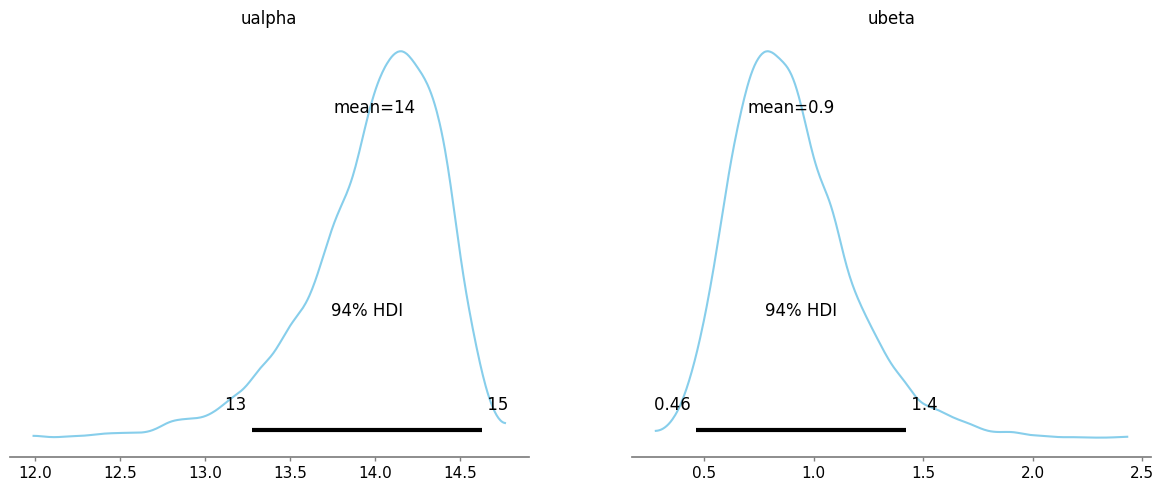

In [16]:
# Plot our posterior pdf for temperature data 

from pymc3 import plot_posterior

plot_posterior(forest_trace[100:], 
                var_names=['ualpha', 'ubeta'],
                color='#87ceeb');

In [17]:
# Calculating mean for ualpha and ubeta 

forest_trace['ualpha'].mean(), forest_trace['ubeta'].mean()

(14.001085315604264, 0.898266856116313)

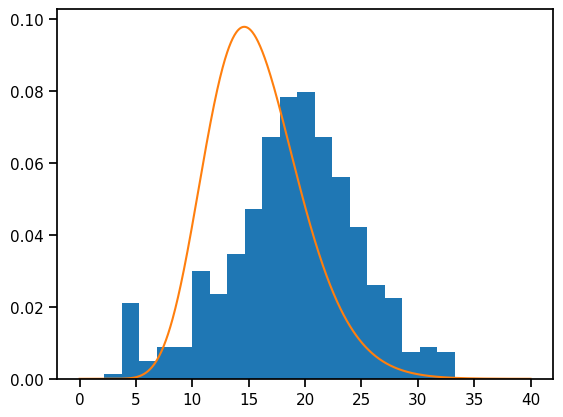

In [21]:
# Checking if our posterior model matches our histogram

We can use the gamma.pdf function in scipy.stats.distributions to plot the distributions implied by the calculated alphas and betas.

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma

ualpha_posterior_mean = 14
ubeta_posterior_mean = 0.89

plt.hist(df.temp, density=True, bins=20)  # df.temp contains temperature data
x_values = np.linspace(0, 40, 1000)
y_values = gamma.pdf(x_values, ualpha_posterior_mean, scale=1/ubeta_posterior_mean)
plt.plot(x_values, y_values)
plt.show()

## Gamma with a uniform distribution seems to be a good fit. But let's explore other distributions too if we can find a better fit

## Modeling Gamma parameters with a Normal distribution

In [22]:
# Calculating mean
temp_mean = df.temp.mean()
temp_mean

18.88916827852998

In [23]:
# Calculating variance

temp_var = df.temp.var()
temp_var

33.71689795030963

In [24]:
# Calculating alpha_mom, beta_mom as we will need it to test Normal Distribution model

alpha_mom = temp_mean ** 2 / temp_var
beta_mom = temp_var / temp_mean
alpha_mom, beta_mom

(10.582251035681255, 1.7849858423164833)

In [26]:
# How about the standard deviation? Well, we have no idea! Let us just pick a value, like 10.

from pymc3 import Model, Uniform, Normal

with Model() as forest_model_normal:
    nalpha = Normal('nalpha', mu=alpha_mom, sd=10)
    nbeta = Normal('nbeta', mu=beta_mom, sd=10)

In [27]:
# Data likelihood modeling

from pymc3 import Gamma
with forest_model_normal:
    forest_like = Gamma('forest_like', alpha=nalpha, beta=nbeta, observed=df.temp)

E:\Anaconda\envs\myenv\lib\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
E:\Anaconda\envs\myenv\lib\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [28]:
# This is the simulation part, the probabilistic program should yield the best values for parameters  𝛼 and  𝛽.

from pymc3 import fit

with forest_model_normal: 
    forest_trace_normal = fit(random_seed=RANDOM_SEED).sample(1000)

E:\Anaconda\envs\myenv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `nalpha`.ravel()[0] is NaN.
The current approximation of RV `nbeta`.ravel()[0] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

#### Oh crap! My simulation bombed! I got a NaN result (probably some division by zero).

#### Back to the drawing board!

#### Let's try.... an exponential distribution for our model parameters?

## Modeling Gamma parameters with an exponential distribution

C:\Users\Abhinav Uni\AppData\Local\Temp\ipykernel_13396\2165341051.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Exponential.dist(1/3).random(size=10000), kde=False)


<Axes: >

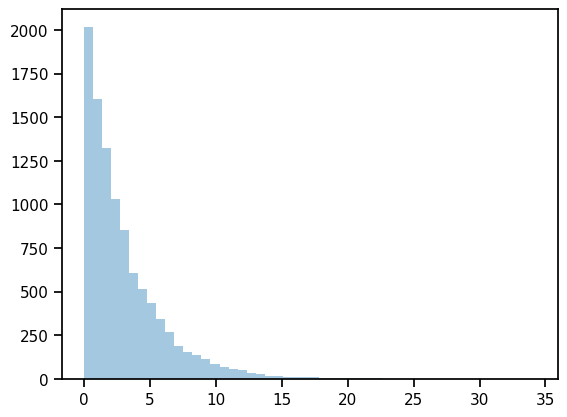

In [29]:
# Find the right number 𝑥 so that the distribution covers the range of possible temperature values

from pymc3 import Exponential
sns.distplot(Exponential.dist(1/3).random(size=10000), kde=False)

In [30]:
# modeling model parameters

from pymc3 import Model, Exponential

with Model() as forest_model_exponential:
    ealpha = Exponential('ealpha', 1/3.)
    ebeta = Exponential('ebeta', 1/3.)

In [31]:
from pymc3 import fit

with forest_model_exponential: 
    forest_trace_exponential = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 0.29366


Got error No model on context stack. trying to find log_likelihood in translation.


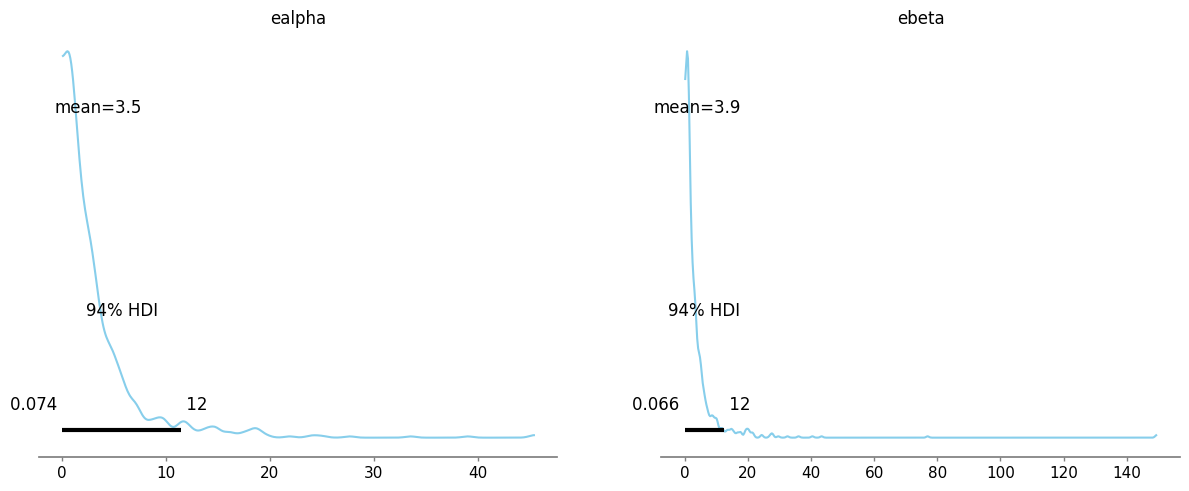

In [32]:
#plot posterior graph for exponential distribution

from pymc3 import plot_posterior

plot_posterior(forest_trace_exponential[100:], 
                var_names=['ealpha', 'ebeta'],
                color='#87ceeb');

In [33]:
forest_trace_exponential['ealpha'].mean(), forest_trace_exponential['ebeta'].mean()

(3.774583169247172, 3.882714353592055)

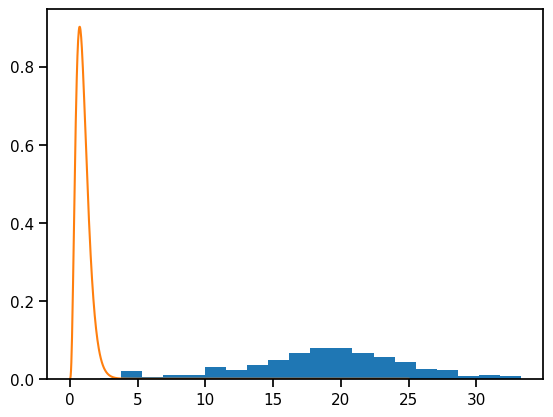

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma

# Forest_trace_exponential is a DataFrame with 'ealpha' and 'ebeta' columns

ealpha_posterior_mean = forest_trace_exponential['ealpha'].mean()
ebeta_posterior_mean = forest_trace_exponential['ebeta'].mean()

plt.hist(df.temp, density=True, bins=20)  # Assuming df.temp contains your temperature data
x_values = np.linspace(0, 25, 1000)
y_values = gamma.pdf(x_values, a=ealpha_posterior_mean, scale=1/ebeta_posterior_mean)  # 'a' is shape parameter
plt.plot(x_values, y_values)
plt.show()

## Our gamma function with exponential distribution is unfit for our dataset

### Let's check our MOM and MLE approaches for fit and compare if they perform better than the gamma with uniform distribution model

In [49]:
# Finding Alpha and Beta paramenters

mean = df['temp'].mean()
var = df['temp'].var()
print("Mean: ", mean, "\nVariance: ", var)
alpha_mom = (mean ** 2)/var
beta_mom = var/mean

alpha_mom, beta_mom

Mean:  18.88916827852998 
Variance:  33.71689795030963


(10.582251035681255, 1.7849858423164833)

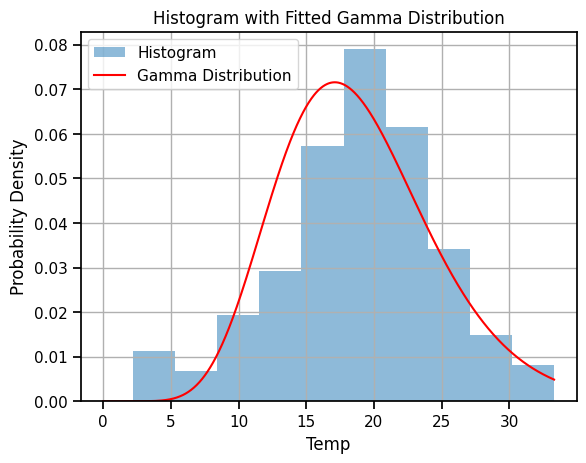

In [50]:
from scipy.stats.distributions import gamma

x = np.linspace(0, max(df['temp']), 1000)  # Generate x values for plotting
pdf = gamma.pdf(x, alpha_mom, scale=beta_mom)  # Compute the PDF of the fitted gamma distribution

# Plot histogram of data
plt.hist(df['temp'], density=True, alpha=0.5, label='Histogram')

# Plot fitted gamma distribution
plt.plot(x, pdf, 'r-', label='Gamma Distribution')

plt.xlabel('Temp')
plt.ylabel('Probability Density')
plt.title('Histogram with Fitted Gamma Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
from scipy.special import psi, polygamma
from scipy.optimize import newton

# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [52]:
# Calculating log_mean and mean_Log

log_mean = np.log(df['temp'].mean())
mean_log = np.log(df['temp']).mean()

log_mean, mean_log

(2.9385886508209462, 2.8755428852335845)

In [53]:
#Calculating alpha mle

alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean, mean_log))
alpha_mle

8.09380816244548

In [54]:
# Calculating beta mle
beta_mle = alpha_mle/mean_log
beta_mle

2.8147061217582947

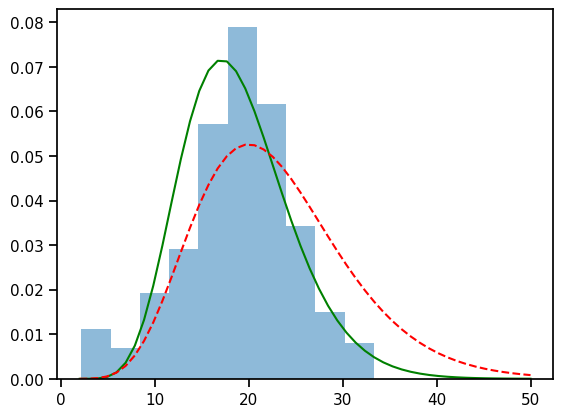

In [55]:
# Ploting MOM and MLE

from scipy.stats.distributions import gamma

data = df['temp']
#shape_mle, loc_mle, scale_mle = gamma.fit(df['L'])

data.hist(density=True, alpha=0.5, grid=False)
x = np.linspace(2, data.max()*1.5)
plt.plot(x, gamma.pdf(x, alpha_mom, scale=beta_mom), 'g-')
plt.plot(x, gamma.pdf(x, alpha_mle, scale=beta_mle), 'r--')

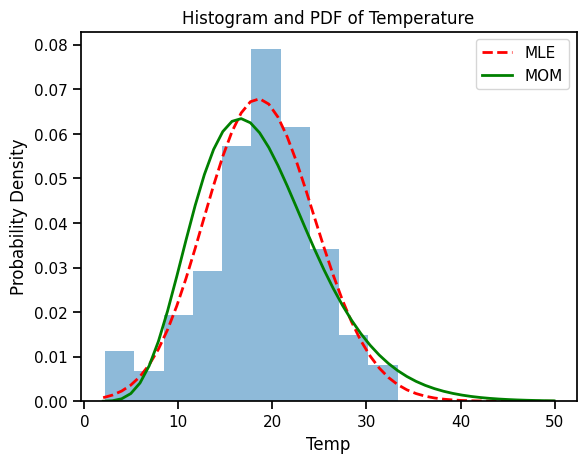

In [56]:
alpha_mle, loc_mle, beta_mle = gamma.fit(df['temp'])
"""

The gamma.fit() function estimates the parameters using the method of maximum likelihood estimation (MLE). 
It returns the shape (alpha), location (shift), and scale (beta) parameters of the fitted distribution. 

"""

plt.hist(df['temp'], alpha=0.5, density=True) # Plotting histogram

pdf_mle = gamma.pdf(x, alpha_mle, loc=loc_mle, scale=beta_mle) # Plotting MLE
plt.plot(x, pdf_mle, 'r--', linewidth=2, label="MLE")

alpha_mom, loc_mom, beta_mom = gamma.fit(df['temp'], floc=0)
"""

The gamma.fit() function estimates the parameters using the method of moments (MOM). 
It returns the shape (alpoha), location (shift), and scale (beta) parameters of the fitted distribution.

"""
pdf_mom = gamma.pdf(x, alpha_mom, loc=loc_mom, scale=beta_mom)
plt.plot(x, pdf_mom, 'g-', linewidth=2, label="MOM")

# Adding labels and title
plt.xlabel('Temp')
plt.ylabel('Probability Density')
plt.title('Histogram and PDF of Temperature')

# Show the plot
plt.legend()
plt.show()

## 2. Which method is more correct, which was the most natural to you?

### Conclusion: After comparing our gamma with uniform distribution model with MOM and MLE models, we can conclucde that MLE model is a most optimal fit for the forest fires dataset. MOM model and gamma with uniform distribution are relatively close. Gamma with normal and exponential distribution are unfit for the dataset.